In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
byrd_bedmap_points = pd.read_csv('/home/kim/ice_thickness/data/byrd_200km.csv')
path_to_file_server = 'data/byrd_bedmachine.nc'
byrd_bedmachine = xr.open_dataset(path_to_file_server)

In [4]:
byrd_bedmachine.bed.values.shape

(400, 400)

# Count per grid cell

Assign IDs and groupby pixel IDs to then compute std, count and mean
Sample minimum one per grid cell

In [5]:
byrd_bedmap_points_assigned = pd.read_csv('/home/kim/ice_thickness/data/byrd_200km_assigned_to_pixels.csv')

## Create IDs

In [6]:
# Make categocial column based on grid cell index
byrd_bedmap_points_assigned["id_500"] = byrd_bedmap_points_assigned["x_pixel_center"].astype(int).astype(str) + "_" + byrd_bedmap_points_assigned["y_pixel_center"].astype(int).astype(str)

# Group by

400 x 400 cells

In [7]:
# Rate of grid cells with assigned points
byrd_bedmap_points_assigned.groupby("id_500").size().sort_values(ascending = False).shape[0]/(400*400)

0.17030625

In [52]:
means_per_pixel = byrd_bedmap_points_assigned.loc[:, ["id_500", "t"]].groupby("id_500").mean()

std_per_pixel = byrd_bedmap_points_assigned.loc[:, ["id_500", "t"]].groupby("id_500").std()
# std is NaN for grid cells with only one point assigned

sem_per_pixel = byrd_bedmap_points_assigned.loc[:, ["id_500", "t"]].groupby("id_500").sem()
# std / np.art(count)

count_per_pixel = byrd_bedmap_points_assigned.loc[:, ["id_500", "t"]].groupby("id_500").count()

combined_metrics = pd.DataFrame(means_per_pixel.index.values, columns = ["center_index"])
combined_metrics["t_mean"] = means_per_pixel["t"].values
combined_metrics["t_std"] = std_per_pixel["t"].values
combined_metrics["t_count"] = count_per_pixel["t"].values
combined_metrics["t_sem"] = sem_per_pixel["t"].values

In [67]:
combined_metrics

,center_index,t_mean,t_std,t_count,t_sem
0,350000_-980000,95.892778,5.365275,18,1.264607
1,350000_-990500,640.070000,NaN,1,NaN
2,350000_-991000,670.948182,17.315805,11,5.220912
3,350000_-999000,744.478000,3.212053,10,1.015740
4,350500_-980000,88.767143,3.491351,35,0.590146
...,...,...,...,...,...
27244,549500_-931000,1814.238750,6.377909,8,2.254931
27245,549500_-931500,1841.431818,11.084475,11,3.342095
27246,549500_-972500,2167.790000,2.540020,9,0.846673
27247,549500_-997500,1115.707500,6.228084,4,3.114042


# Add this to a xarray dataset

In [68]:
centers = [i.split("_") for i in combined_metrics.center_index.values.astype(str)]

# Add standard error of the mean
combined_metrics["t_sem_check"] = combined_metrics["t_std"] / np.sqrt(combined_metrics["t_count"])

# Add column one and 2
combined_metrics["x"] = np.array(centers).astype(int)[:, 0]
combined_metrics["y"] = np.array(centers).astype(int)[:, 1]

# Mean error per gridcell (median is only 9 m)
# Screwed: remote cells with super high std
combined_metrics.t_std.mean()
combined_metrics.t_std.describe()

count    26260.000000
mean        18.230413
std         45.952715
min          0.000000
25%          4.392811
50%          9.490620
75%         19.132974
max       1159.894840
Name: t_std, dtype: float64

In [69]:
combined_metrics[combined_metrics.t_std > 1000]

,center_index,t_mean,t_std,t_count,t_sem,t_sem_check,x,y
436,367500_-993000,1990.335106,1007.037126,47,146.891462,146.891462,367500,-993000
437,367500_-993500,1859.711000,1033.107822,10,326.697379,326.697379,367500,-993500
525,369000_-991500,1789.108333,1007.949520,6,411.493668,411.493668,369000,-991500
6049,414500_-916500,1611.446667,1159.894840,12,334.832799,334.832799,414500,-916500


# Go from table to mesh

In [71]:
xx, yy = np.meshgrid(byrd_bedmachine.bed.x, byrd_bedmachine.bed.y)
flat_grid = pd.DataFrame({"x": xx.reshape(-1), "y": yy.reshape(-1)})

In [74]:
combined_metrics

,center_index,t_mean,t_std,t_count,t_sem,t_sem_check,x,y
0,350000_-980000,95.892778,5.365275,18,1.264607,1.264607,350000,-980000
1,350000_-990500,640.070000,NaN,1,NaN,NaN,350000,-990500
2,350000_-991000,670.948182,17.315805,11,5.220912,5.220912,350000,-991000
3,350000_-999000,744.478000,3.212053,10,1.015740,1.015740,350000,-999000
4,350500_-980000,88.767143,3.491351,35,0.590146,0.590146,350500,-980000
...,...,...,...,...,...,...,...,...
27244,549500_-931000,1814.238750,6.377909,8,2.254931,2.254931,549500,-931000
27245,549500_-931500,1841.431818,11.084475,11,3.342095,3.342095,549500,-931500
27246,549500_-972500,2167.790000,2.540020,9,0.846673,0.846673,549500,-972500
27247,549500_-997500,1115.707500,6.228084,4,3.114042,3.114042,549500,-997500


In [73]:
flat_grid

,x,y
0,350000,-800500
1,350500,-800500
2,351000,-800500
3,351500,-800500
4,352000,-800500
...,...,...
159995,547500,-1000000
159996,548000,-1000000
159997,548500,-1000000
159998,549000,-1000000


In [79]:
flat_grid_merged = flat_grid.merge(combined_metrics, on = ["x", "y"], how = "left")

In [91]:
flat_grid_merged

,x,y,center_index,t_mean,t_std,t_count,t_sem,t_sem_check
0,350000,-800500,NaN,NaN,NaN,NaN,NaN,NaN
1,350500,-800500,NaN,NaN,NaN,NaN,NaN,NaN
2,351000,-800500,NaN,NaN,NaN,NaN,NaN,NaN
3,351500,-800500,NaN,NaN,NaN,NaN,NaN,NaN
4,352000,-800500,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
159995,547500,-1000000,547500_-1000000,1556.340769,131.891521,26.0,25.866055,25.866055
159996,548000,-1000000,548000_-1000000,1505.013571,187.765143,14.0,50.182345,50.182345
159997,548500,-1000000,NaN,NaN,NaN,NaN,NaN,NaN
159998,549000,-1000000,NaN,NaN,NaN,NaN,NaN,NaN


### Add to Xarray Dataset

In [92]:
byrd_bedmachine["pt_t_mean"] = (byrd_bedmachine.bed.dims, flat_grid_merged["t_mean"].values.reshape(byrd_bedmachine.bed.shape))
byrd_bedmachine["pt_t_std"] = (byrd_bedmachine.bed.dims, flat_grid_merged["t_std"].values.reshape(byrd_bedmachine.bed.shape))
byrd_bedmachine["pt_t_sem"] = (byrd_bedmachine.bed.dims, flat_grid_merged["t_sem"].values.reshape(byrd_bedmachine.bed.shape))
byrd_bedmachine["pt_t_count"] = (byrd_bedmachine.bed.dims, flat_grid_merged["t_count"].values.reshape(byrd_bedmachine.bed.shape))

# Visualise

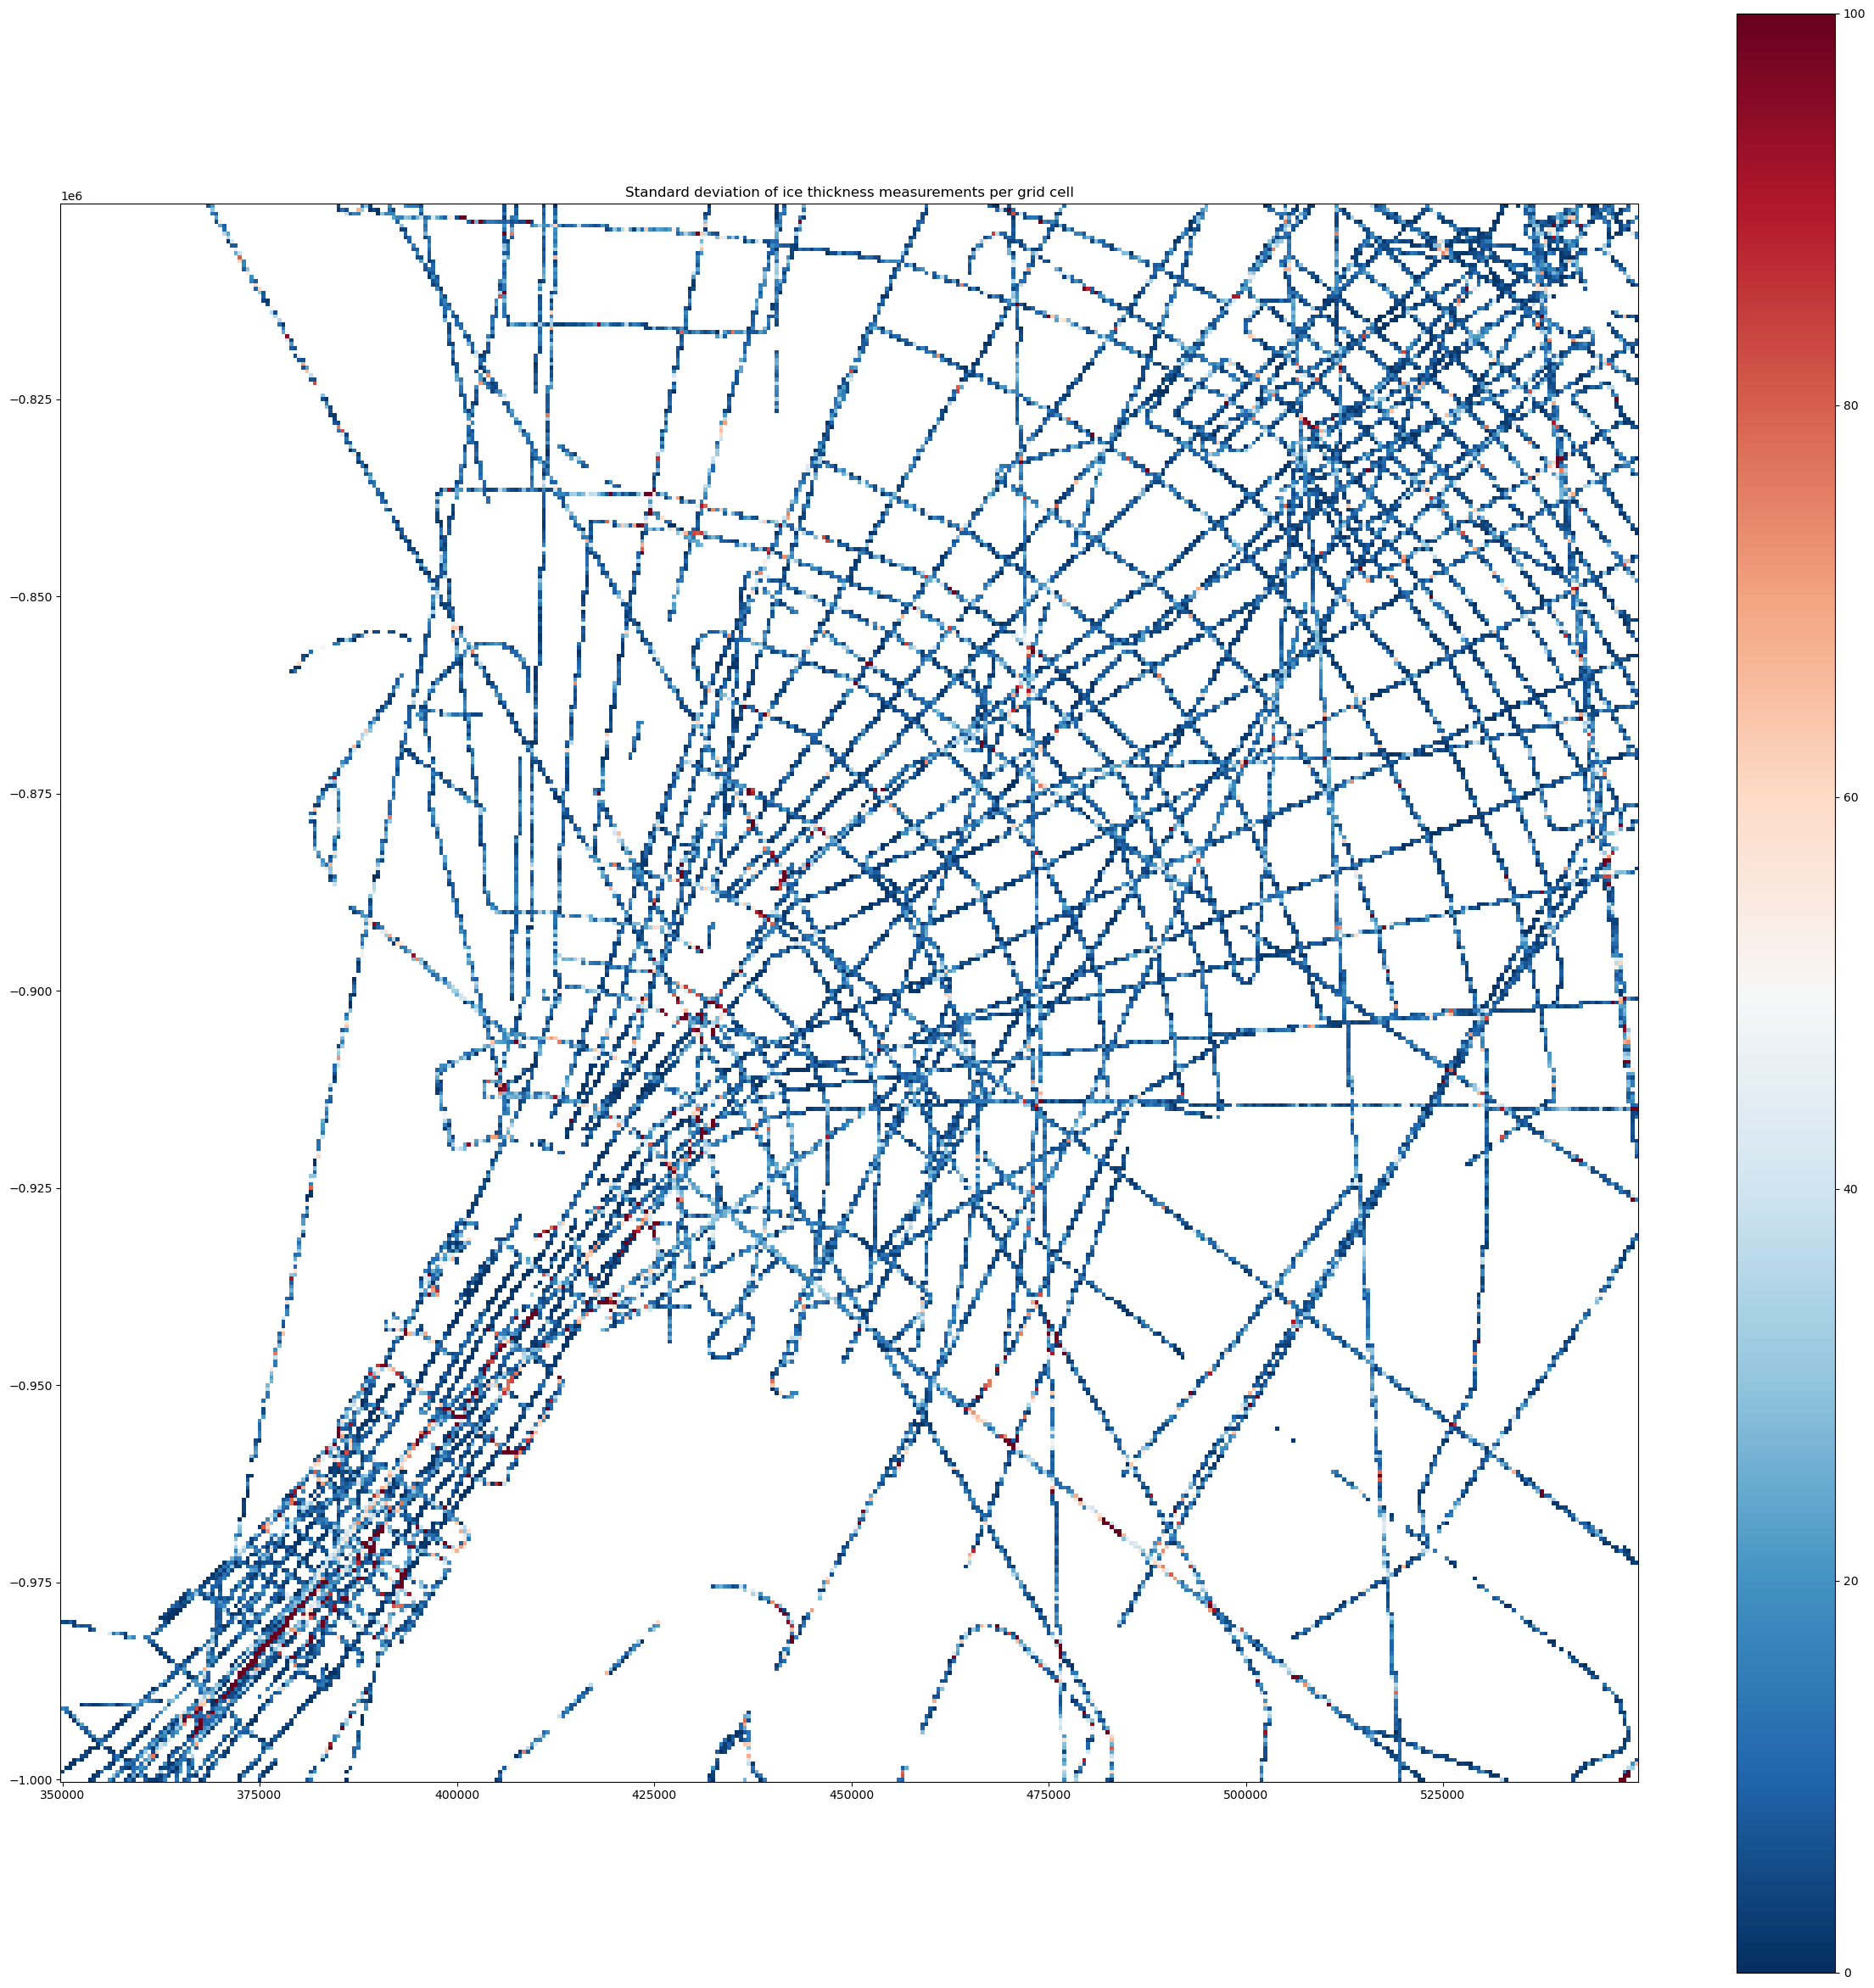

In [112]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (30, 30))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.pt_t_std, cmap = "RdBu_r", vmin = 0, vmax = 100)

fig.colorbar(mappable = ax.collections[0], ax = ax)
plt.title('Standard deviation of ice thickness measurements per grid cell')
ax.set_aspect('equal')

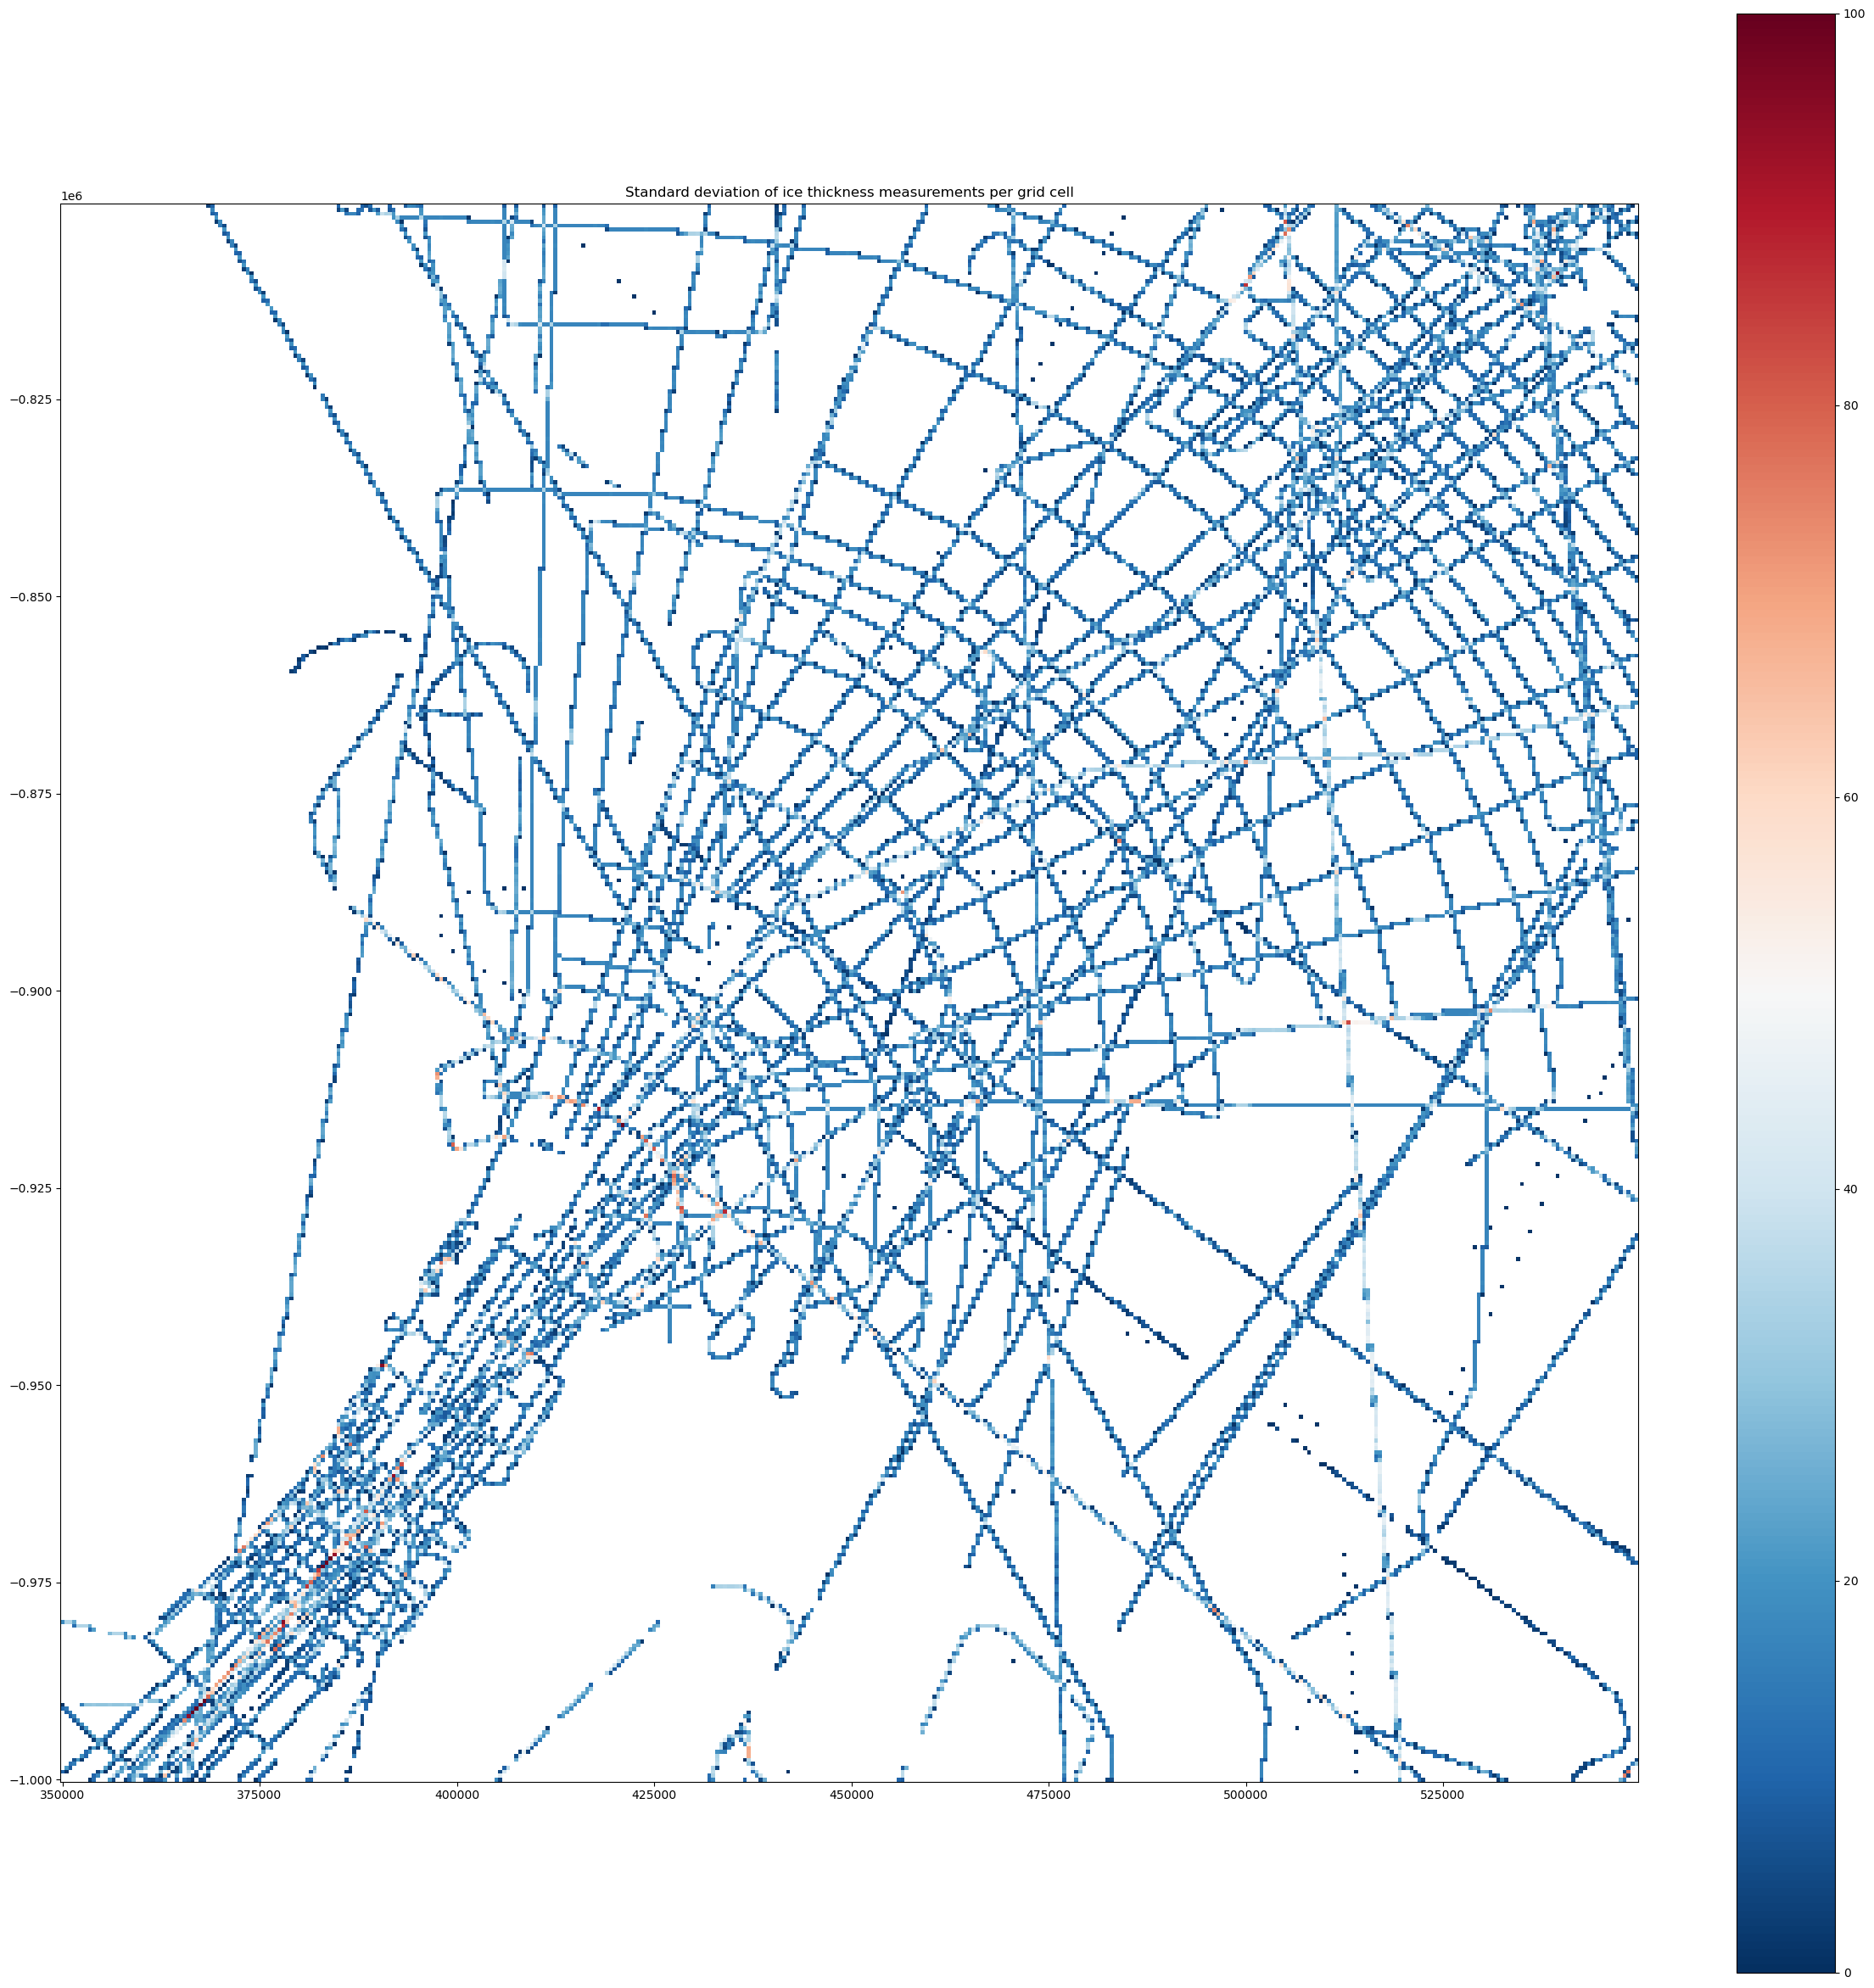

In [114]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (30, 30))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.pt_t_count, cmap = "RdBu_r", vmin = 0, vmax = 100)

fig.colorbar(mappable = ax.collections[0], ax = ax)
plt.title('Number of ice thickness measurements per grid cell')
ax.set_aspect('equal')

In [118]:
cvals  = [0, 
          1, 250, 500, 750, 1000]

colors = ["#7eb3a1",
          "#bee6fa", "#47bdfc", "#006cef", "#0023c1", "#001079"]

# Create a colormap object
norm = plt.Normalize(np.min(cvals), np.max(cvals))
tuples = list(zip(map(norm, cvals), colors))

icethickness_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

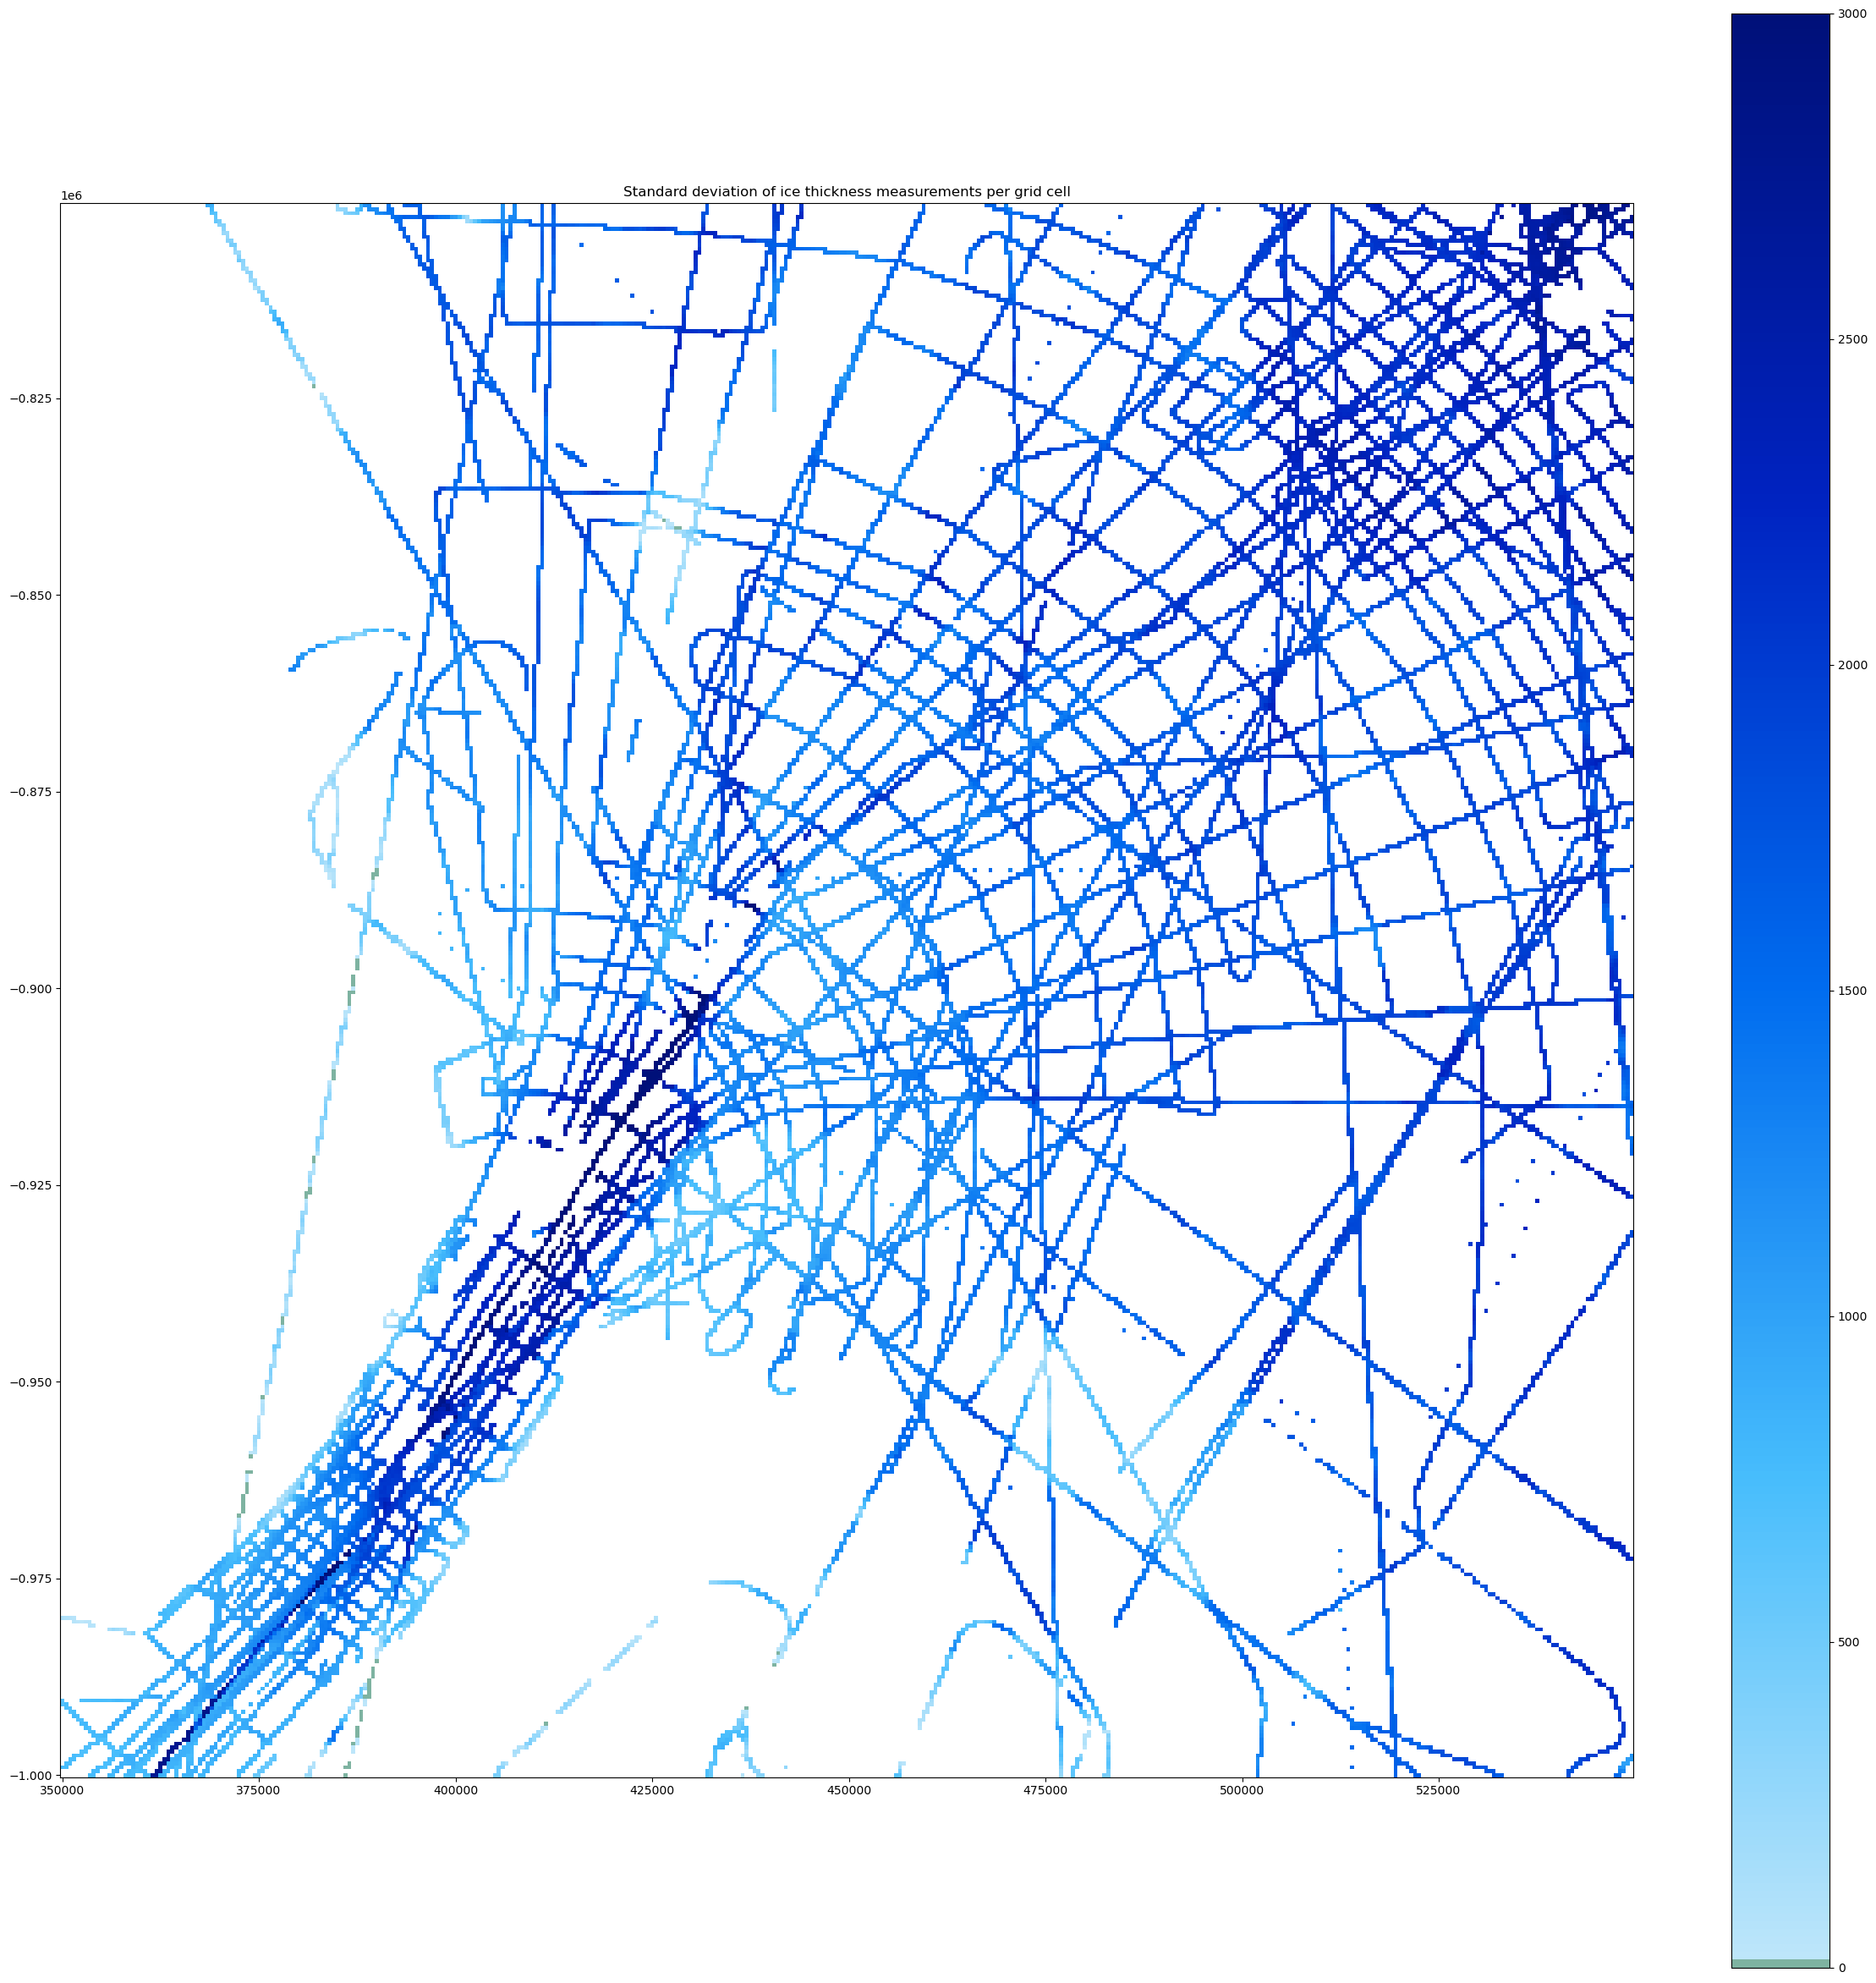

In [119]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (30, 30))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.pt_t_mean, cmap = icethickness_cmap, vmin = 0, vmax = 3000)

fig.colorbar(mappable = ax.collections[0], ax = ax)
plt.title('Standard deviation of ice thickness measurements per grid cell')
ax.set_aspect('equal')

In [121]:
byrd_bedmachine["thickness_ellipsoid"] = byrd_bedmachine["thickness"] + byrd_bedmachine["geoid"]
byrd_bedmachine["thickness_ellipsoid_true"] = byrd_bedmachine["thickness_ellipsoid"] + byrd_bedmachine["firn"]

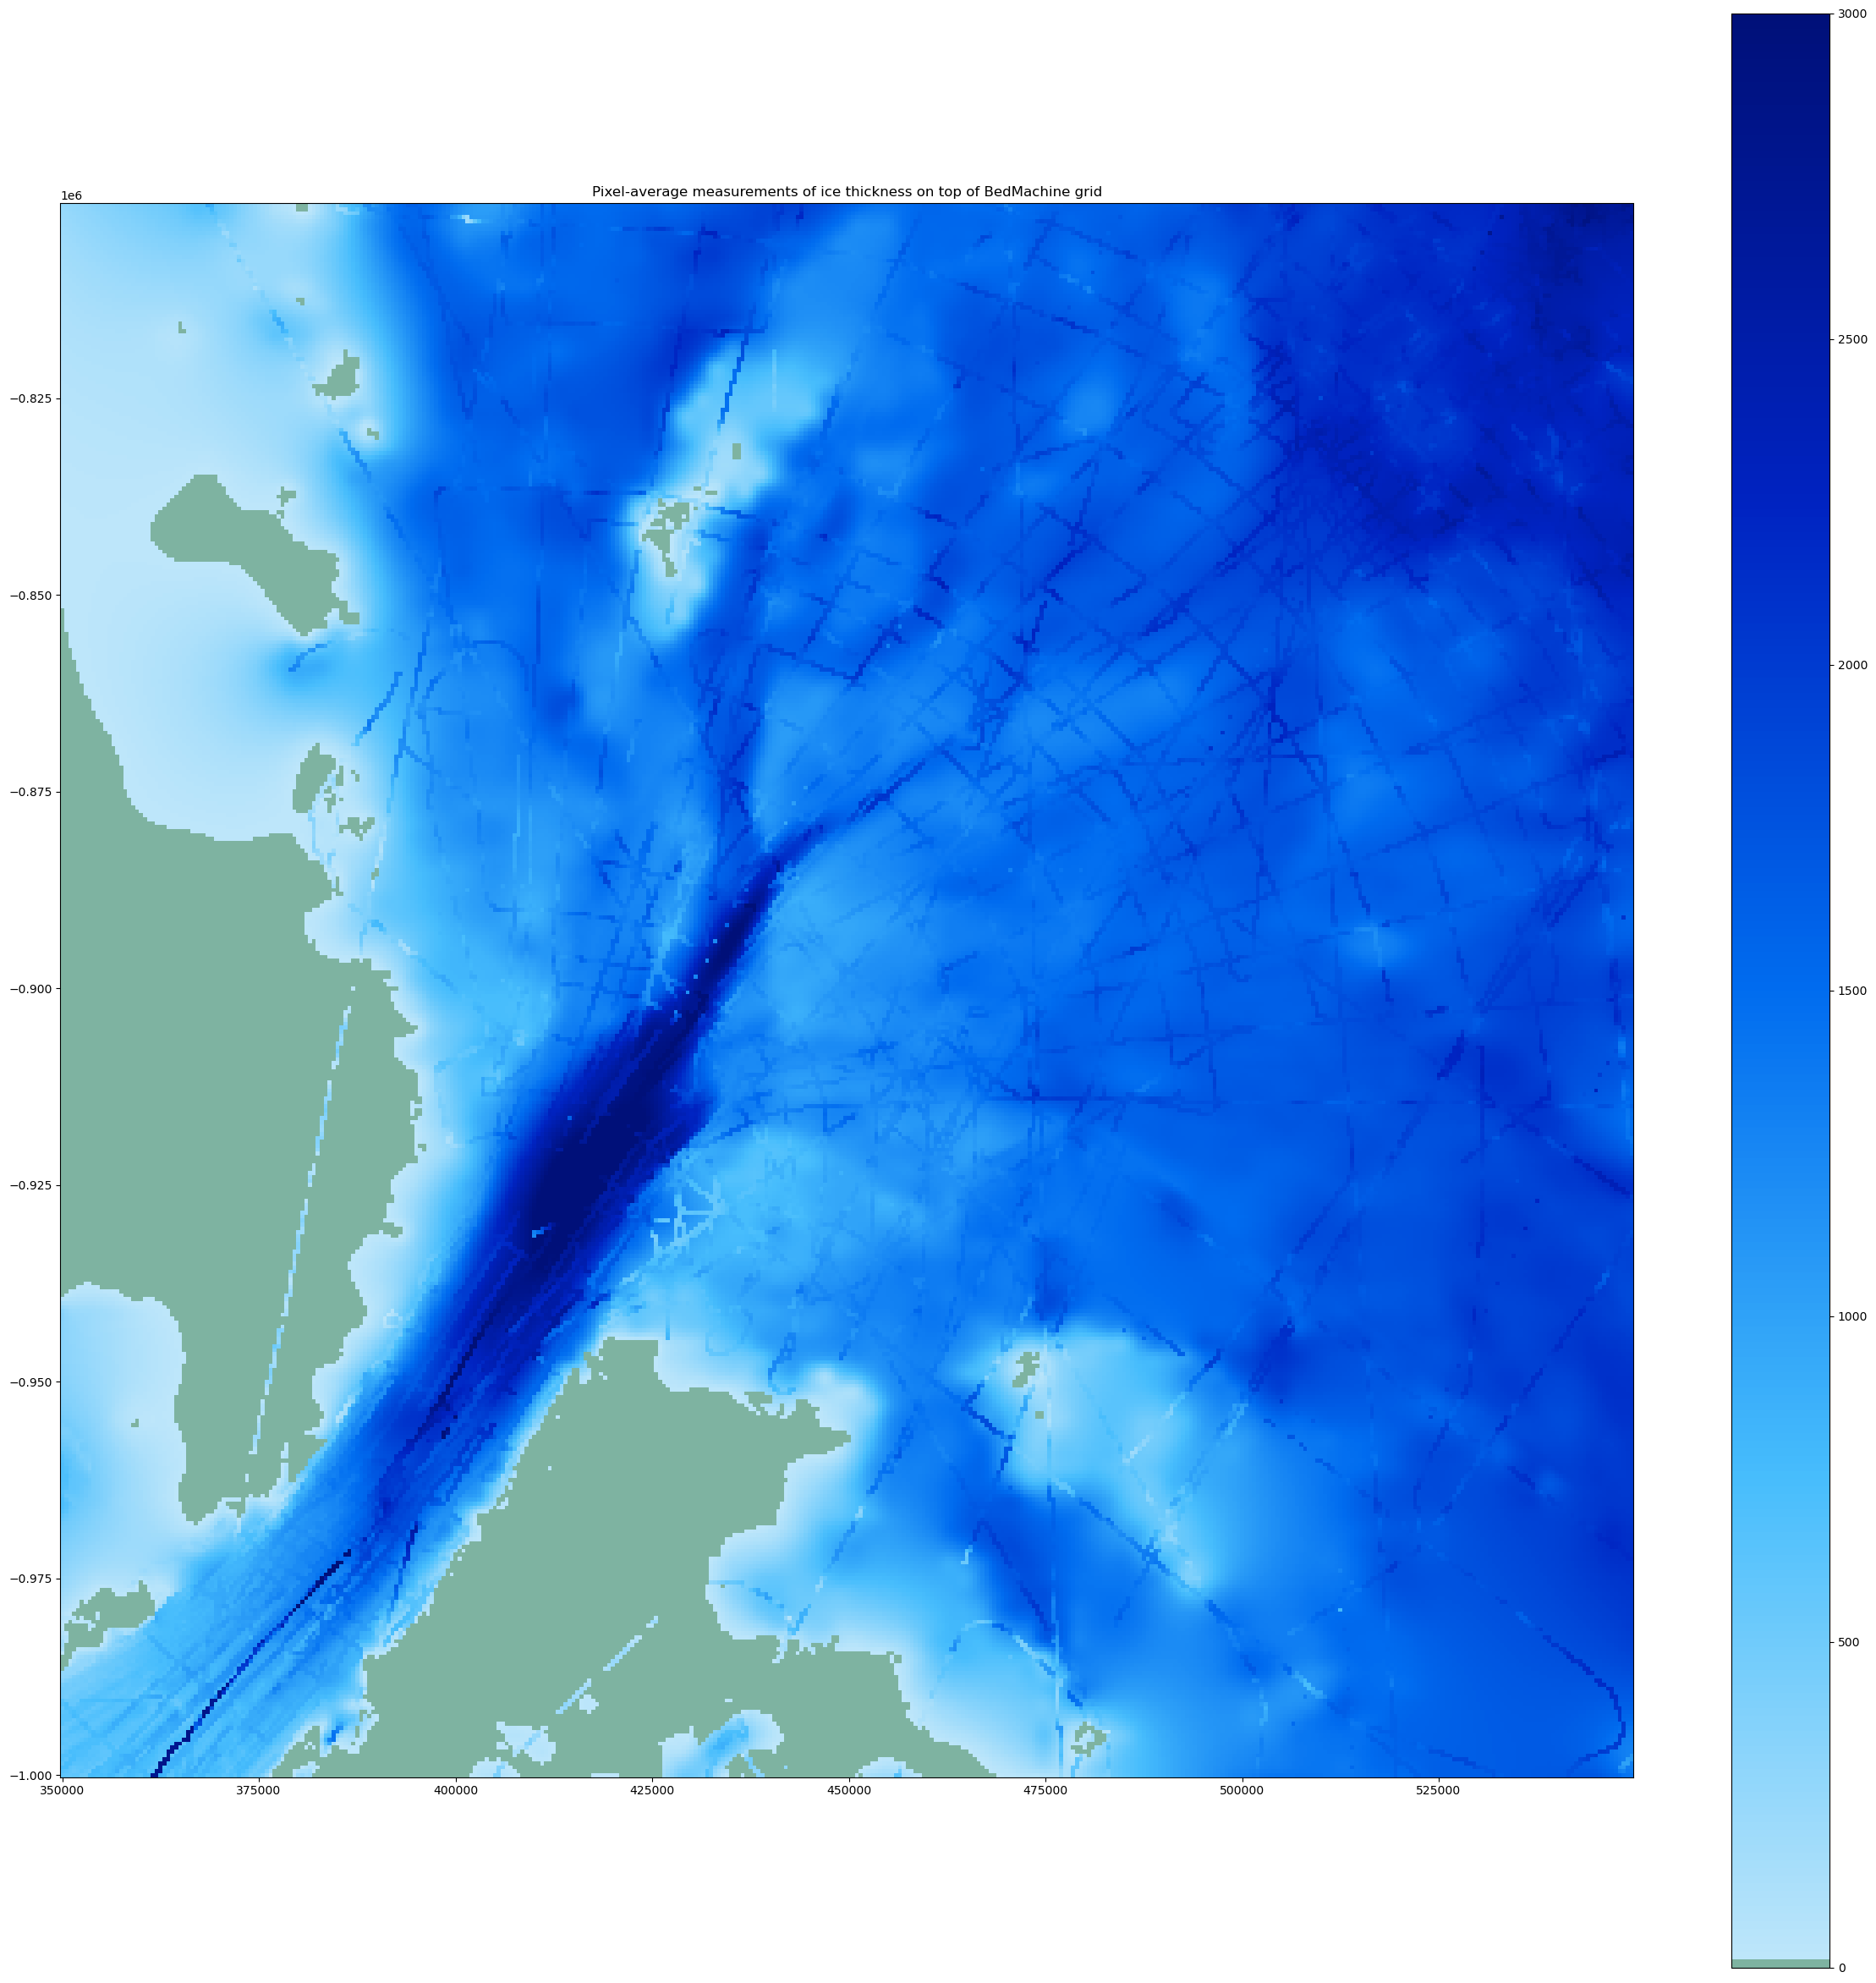

In [124]:
XX, YY = np.meshgrid(byrd_bedmachine.x, byrd_bedmachine.y)

fig, ax = plt.subplots(figsize = (30, 30))

# Plot bed topography mesh
ax.pcolormesh(XX, YY, byrd_bedmachine.thickness_ellipsoid_true, cmap = icethickness_cmap, vmin = 0, vmax = 3000)
ax.pcolormesh(XX, YY, byrd_bedmachine.pt_t_mean, cmap = icethickness_cmap, vmin = 0, vmax = 3000)

fig.colorbar(mappable = ax.collections[0], ax = ax)
plt.title('Pixel-average measurements of ice thickness on top of BedMachine grid')
ax.set_aspect('equal')